# LSTM, State Space, and Mixture Models on economic series

Apply and compare methods for extracting lower-dimensional states
from a large panel of economic time series: State space models, Hidden
Markov Models, Gaussian mixtures, and LSTM networks.

Use BIC criterion, visualize the extracted hidden states/latent factors 
in recessionary and economic time periods, and compare persistence.

- Long Short-Term Memory network, hidden states, state space model, mixture models
- BIC, log-likelihood, mixed-frequency
- pytorch, hmmlearn, statsmodels, sklearn, FRED-MD
- Chen, Pelger and Zhu (2020) and others

Terence Lim
License: MIT


Terence Lim

In [2]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import os
import re
import time
from datetime import datetime
import statsmodels.api as sm
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from hmmlearn import hmm
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from finds.alfred import fred_md, fred_qd, Alfred
from finds.learning import hmm_summary
from settings import settings
imgdir = os.path.join(settings['images'], 'rnn')

# Load time series from FRED and FRED-MD, and apply tcode transformations

In [3]:
# Load and pre-process time series from FRED
alf = Alfred(api_key=settings['fred']['api_key'])

# to indicate recession periods in the plots
usrec = alf('USREC', freq='m')
usrec.index = pd.DatetimeIndex(usrec.index.astype(str), freq='infer')
g = usrec.astype(bool) | usrec.shift(-1, fill_value=0).astype(bool)
g = (g != g.shift(fill_value=0)).cumsum()[g].to_frame()
g = g.reset_index().groupby('USREC')['date'].agg(['first','last'])
vspans = [(v[0], v[1]) for k, v in g.iterrows()]

# Retrieve FRED-MD series and apply tcode transformations
beg = 19600301
end = 20200131

df, t = fred_md(202004)      # from vintage April 2020
data = []
for col in df.columns:
    data.append(alf.transform(df[col], tcode=t['transform'][col], freq='m'))
mdf = pd.concat(data, axis=1).iloc[2:]

mdata = mdf[(mdf.index >= beg) & (mdf.index <= end)].dropna(axis=1)
mdata = (mdata - mdata.mean(axis=0)) / mdata.std(axis=0, ddof=0)
mdata.index = pd.DatetimeIndex(mdata.index.astype(str), freq='m')
mdata

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPL,RETAIL,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST
1960-03-31,-0.134881,-0.275771,2.216461,-2.860458,-0.488916,-1.494126,-0.747423,-0.399146,-0.045307,-1.035927,...,-1.469820,0.295721,-0.643390,-0.003771,3.306562,-1.010361,0.316937,0.142584,0.047443,0.324377
1960-04-30,0.140605,0.203278,2.471089,0.718774,1.808191,-1.351744,0.044685,-0.109636,0.617368,-0.158355,...,1.329945,0.735110,0.960469,-2.253155,-7.467190,0.001676,-0.193935,0.356025,0.269794,2.267079
1960-05-31,-0.045275,-0.004559,-4.482796,-3.197753,-1.675079,-0.432646,0.516409,0.612768,0.480566,0.339132,...,-0.418471,-1.113542,0.316095,2.255746,4.566901,0.001676,0.188096,-0.197676,-0.101655,0.353369
1960-06-30,-0.338482,-0.482476,-0.559540,0.602494,-0.511228,-1.983791,-1.854133,-1.702628,-0.970468,-0.600344,...,-0.849520,0.036686,-0.482642,-1.125930,-1.252825,0.001676,0.186521,0.210401,0.367009,-0.943151
1960-07-31,-0.148985,-0.100803,-0.122954,-0.860250,-1.254201,-0.747608,-1.070579,-0.984785,-1.243071,-1.916083,...,0.918360,0.302768,0.421378,1.123500,0.828946,0.001676,0.247264,-0.447705,-0.162111,3.023607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-09-30,-0.079715,-0.081618,-0.174630,-0.239203,-0.752893,-0.747932,-1.076215,-1.247348,-0.984334,-1.453438,...,-0.071819,-0.163996,-0.071125,-0.204290,-0.307419,0.098370,0.138877,-0.163879,-0.281842,0.375870
2019-10-31,-0.598714,-0.639323,-0.385917,-0.656535,-0.108856,-0.828301,-0.648297,-0.596663,-0.251664,-1.417370,...,0.074042,1.267315,0.290075,-0.202566,0.000637,0.000978,0.522365,0.080482,0.200078,-1.320725
2019-11-30,0.202376,0.355149,-0.057531,0.283946,-0.217945,0.983266,1.686887,2.054174,2.128329,2.857134,...,-0.704147,-0.295116,-0.421273,-0.201345,-0.037554,0.484033,-0.370009,-0.095845,-0.056103,0.600435
2019-12-31,-0.644414,-0.535997,-0.324231,-0.230203,-0.374542,-0.815438,-1.127034,-1.336095,-1.517772,-1.297690,...,-0.239385,0.522518,1.193464,0.604609,0.457551,-0.386623,-0.767687,0.246058,0.036262,-0.996952


## Load FRED-QD and apply tcode transformations

In [4]:
df, t = fred_qd(202004)      # from vintage April 2020
data = []
for col in df.columns:
    data.append(alf.transform(df[col], tcode=t['transform'][col], freq='q'))
df = pd.concat(data, axis=1).iloc[2:]

qdata = df[(df.index >= beg) & (df.index <= end)].dropna(axis=1)
qdata.index = pd.DatetimeIndex(qdata.index.astype(str), freq='q')
qdata

,GDPC1,PCECC96,PCDG,PCESV,PCND,GPDIC1,FPI,Y033RC1Q027SBEA,PNFI,PRFI,...,TLBSNNB,TLBSNNBBDI,TABSNNB,TNWBSNNB,TNWBSNNBBDI,CNCF,S&P 500,S&P: indust,S&P div yield,S&P PE ratio
1960-03-31,0.022224,0.009521,0.031666,0.009043,0.002506,0.095788,0.032856,0.034200,0.034166,0.030306,...,0.037652,279155.40,0.009183,0.004308,86.68,-0.051251,-0.026073,-0.029896,0.2278,-0.057371
1960-06-30,-0.005408,0.012535,0.022501,0.011003,0.010896,-0.097837,-0.018342,0.016711,0.014503,-0.085422,...,0.018321,280144.95,0.003057,0.000375,-22.94,0.014782,-0.003680,-0.006778,0.0876,-0.024349
1960-09-30,0.004881,-0.004005,-0.008030,-0.001174,-0.005880,-0.002544,-0.021666,-0.044133,-0.017656,-0.030290,...,0.018804,275164.71,0.007952,0.006017,-47.83,0.036742,-0.006262,-0.012285,0.0276,0.001369
1960-12-31,-0.012917,0.001294,-0.025450,0.009625,0.000690,-0.117411,-0.001999,-0.035770,-0.002352,-0.001084,...,-0.005096,273738.35,0.003843,0.005440,8.20,0.000101,-0.006964,-0.006569,0.0257,0.000796
1961-03-31,0.006728,-0.000372,-0.056541,0.009798,0.005951,0.025621,-0.008523,-0.033095,-0.014372,0.003940,...,0.038024,291545.95,0.009200,0.003994,45.35,-0.025001,0.113813,0.111342,-0.3889,0.128986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31,0.002710,0.003565,0.003155,0.003444,0.004208,0.007390,0.006561,0.017770,0.011718,-0.011973,...,0.021630,398935.93,0.013740,0.008576,12.73,-0.012680,-0.057381,-0.058307,0.1617,-0.098323
2019-03-31,0.007623,0.002829,0.000639,0.002416,0.005331,0.014937,0.007913,-0.000245,0.010812,-0.002634,...,0.014793,399732.21,0.016181,0.017095,2.61,0.012799,0.011111,0.011686,0.0233,-0.033627
2019-06-30,0.004985,0.011135,0.030572,0.006846,0.015664,-0.016345,-0.003600,0.002076,-0.002531,-0.007507,...,0.004232,392693.84,0.011550,0.016331,-3.44,0.021996,0.057399,0.059265,-0.0731,0.013658
2019-09-30,0.005204,0.007750,0.019467,0.005429,0.009520,-0.002477,-0.002080,-0.009578,-0.005777,0.011351,...,0.012694,388971.84,0.013807,0.014530,-4.63,0.022218,0.025918,0.025926,-0.0106,0.004248


# Define LSTM pytorch model

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class LSTM(nn.Module):
    def __init__(self, n_features, hidden_size, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size=n_features,
                            hidden_size=hidden_size,
                            num_layers=num_layers)
        self.linear = nn.Linear(in_features=hidden_size,
                                out_features=n_features)

    def forward(self, x, hidden_state=None):
        """
        x: shape (seq_len, batch, input_siz)
        h: of shape (num_layers * num_directions, batch, hidden_size)
        c: of shape (num_layers * num_directions, batch, hidden_size)
        output: shape (seq_len, batch, num_directions * hidden_size)
        """
        output, (h, c) = self.lstm(x, hidden_state)
        return self.linear(output), (h.detach(), c.detach())


## Create input data for LSTM
- with sequence length 16

In [10]:
seq_len = 16
train_exs = [mdata.iloc[i-(seq_len+1):i].values
             for i in range(seq_len+1, len(mdata))]
n_features = mdata.shape[1]
train_exs[0].shape

(17, 123)

# Run training loop

- for various hidden sizes of LSTM cell from 1,..,4
- minibatch with batch size 32, and learning rate step scheduler

In [12]:
hidden_factors = dict()
prediction_errors = dict()
for hidden_size in [1,2,3,4]:
    model = LSTM(n_features=n_features, hidden_size=hidden_size).to(device)
    print(model)

    # Set optimizer and learning rate scheduler, with step_size=30
    lr, num_lr, step_size = 0.001, 3, 400
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size,
                                                gamma=0.1)
    loss_function = nn.MSELoss()

    batch_size, num_epochs = 32, step_size*num_lr
    for i in tqdm(range(num_epochs)):   # Run training loop per epoch
        idx = np.arange(len(train_exs))  # shuffle indxs into batches
        random.shuffle(idx)
        batches = [idx[i:(i+batch_size)] for i in range(0,len(idx),batch_size)]
        total_loss = 0.0   
        model.train() 
        for batch in batches:    # train each batch
            # train_ex input has shape (seq_len, batch_size=16, n_features)
            train_ex = torch.tensor([[train_exs[idx][seq] for idx in batch]
                                     for seq in range(seq_len+1)]).float()
            model.zero_grad()
            y_pred, hidden_state = model.forward(train_ex[:-1].to(device))
            loss = loss_function(y_pred[-1], train_ex[-1].to(device))
            total_loss += float(loss)
            loss.backward()
            optimizer.step()
        scheduler.step()

    # collect predictions and hidden states, and compute mse
    with torch.no_grad():    # reduce memory consumption for eval
        hidden_state = []
        prediction_error = []
        mse = nn.MSELoss()
        for i in range(seq_len+1, len(mdata)):
            # single test example of shape (seq_len=12, batch_size=1, n_features)
            test_ex = torch.tensor(mdata[i-(seq_len+1):i].values)\
                           .float().unsqueeze(dim=1).to(device)
            y_pred, (h, c) = model.forward(test_ex[:-1], None)
            prediction_error.append(float(mse(y_pred[-1], test_ex[-1])))
            hidden_state.append(h[0][0].cpu().numpy())
    hidden_factors[hidden_size] = DataFrame(
        hidden_state,index=mdata.index[(1+seq_len):len(mdata)])
    prediction_errors[f"Hidden Size {hidden_size}"] = np.mean(prediction_error)
    print(prediction_errors)


  0%|          | 0/1200 [00:00<?, ?it/s]

LSTM(
  (lstm): LSTM(123, 1)
  (linear): Linear(in_features=1, out_features=123, bias=True)
)


  0%|          | 0/1200 [00:00<?, ?it/s]

{'Hidden Size 1': 0.8855123731315645}
LSTM(
  (lstm): LSTM(123, 2)
  (linear): Linear(in_features=2, out_features=123, bias=True)
)


  0%|          | 0/1200 [00:00<?, ?it/s]

{'Hidden Size 1': 0.8855123731315645, 'Hidden Size 2': 0.8053738953084009}
LSTM(
  (lstm): LSTM(123, 3)
  (linear): Linear(in_features=3, out_features=123, bias=True)
)


  0%|          | 0/1200 [00:00<?, ?it/s]

{'Hidden Size 1': 0.8855123731315645, 'Hidden Size 2': 0.8053738953084009, 'Hidden Size 3': 0.7640182351284897}
LSTM(
  (lstm): LSTM(123, 4)
  (linear): Linear(in_features=4, out_features=123, bias=True)
)


100%|██████████| 1200/1200 [06:05<00:00,  3.29it/s]


{'Hidden Size 1': 0.8855123731315645, 'Hidden Size 2': 0.8053738953084009, 'Hidden Size 3': 0.7640182351284897, 'Hidden Size 4': 0.7323627735559757}


# Plot LSTM hidden states process

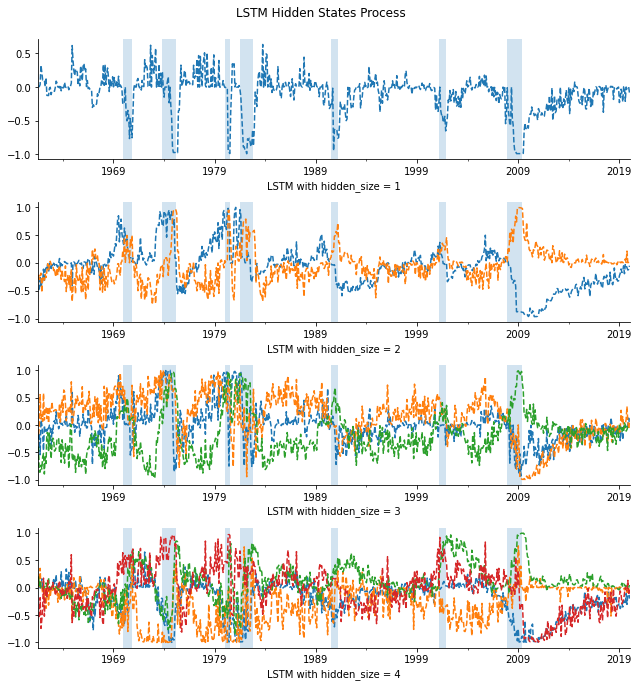

In [13]:
fig, axes = plt.subplots(len(hidden_factors), 1, figsize=(9,10),num=1,clear=True)
for hidden_factor, ax in zip(hidden_factors.values(), axes):
    hidden_factor.plot(ax=ax, style='--', legend=False)
    for a,b in vspans:
        if a >= min(hidden_factor.index):
            ax.axvspan(a, min(b, max(hidden_factor.index)), alpha=0.2)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_xlabel(f"LSTM with hidden_size = {len(hidden_factor.columns)}")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle(f"LSTM Hidden States Process", fontsize=12)
plt.savefig(os.path.join(imgdir, 'lstm.jpg'))
plt.show()

# Dynamic Factor Models

- can be cast into state space form and estimated via Kalman Filter

https://www.statsmodels.org/devel/examples/notebooks/generated/statespace_dfm_coincident.html

## Fit (linear) dynamic factor model with DynamicFactorMQ
https://www.statsmodels.org/devel/generate/statsmodels.tsa.statespace.dynamic_factor_mq.DynamicFactorMQ.html

Allows for

- mixed frequency data (for nowcasting)
- EM algorithm by default accomodates larger data sets:  Kalman filter and optimizing of likelihood with quasi-Newton methods slow

In [14]:
dynamic_factors = dict()
for i in [1, 2, 3, 4]:
    mod = sm.tsa.DynamicFactorMQ(endog=mdata,
                                 factors=1,                # num factor blocks
                                 factor_multiplicities=i,  # num factors in block
                                 factor_orders=2,          # order of factor VAR
                                 idiosyncratic_ar1=False)  # False=white noise
    fitted = mod.fit_em(disp=20, maxiter=200, full_output=True)
    dynamic_factors[i] = DataFrame(fitted.factors.filtered.iloc[seq_len+1:])
    dynamic_factors[i].columns = list(np.arange(len(dynamic_factors[i].columns)))
    mse = nn.MSELoss()
    prediction_errors[f"Dynamic Factors {i}"] = float(
        mse(torch.tensor(fitted.fittedvalues.iloc[mod.factor_orders+1:].values),
            torch.tensor(mdata.iloc[mod.factor_orders+1:].values)))

EM start iterations, llf=-1.1843e+05
EM iteration 20, llf=-1.1774e+05, convergence criterion=3.1004e-05
EM converged at iteration 29, llf=-1.1773e+05, convergence criterion=9.4463e-07 < tolerance=1e-06
EM start iterations, llf=-1.1327e+05
EM iteration 20, llf=-1.1147e+05, convergence criterion=7.3906e-06
EM iteration 40, llf=-1.1146e+05, convergence criterion=2.7273e-06
EM iteration 60, llf=-1.1146e+05, convergence criterion=1.0928e-06
EM converged at iteration 62, llf=-1.1146e+05, convergence criterion=9.9257e-07 < tolerance=1e-06
EM start iterations, llf=-1.0902e+05
EM iteration 20, llf=-1.062e+05, convergence criterion=1.8777e-05
EM iteration 40, llf=-1.0617e+05, convergence criterion=3.7322e-06
EM converged at iteration 56, llf=-1.0617e+05, convergence criterion=9.9476e-07 < tolerance=1e-06
EM start iterations, llf=-1.0478e+05
EM iteration 20, llf=-1.0301e+05, convergence criterion=2.4994e-05
EM iteration 40, llf=-1.0299e+05, convergence criterion=4.3864e-06
EM iteration 60, llf=-1

## Plot estimated dynamic factors

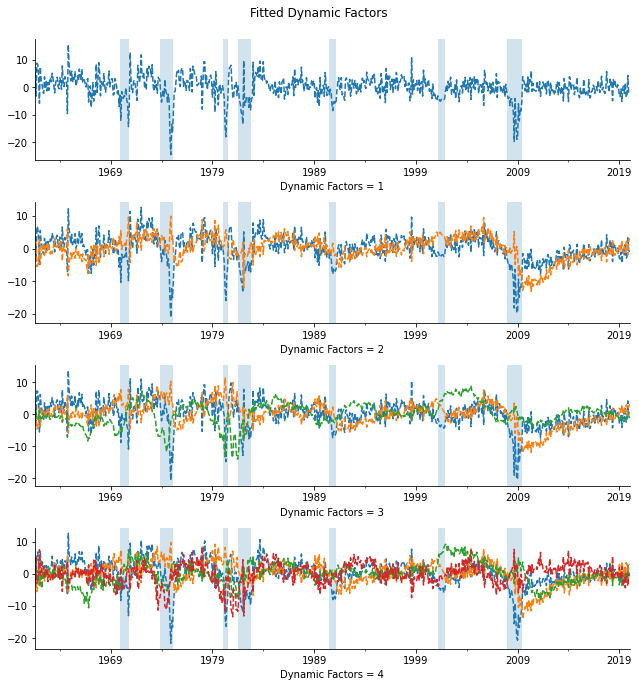

In [15]:
fig, axes = plt.subplots(len(dynamic_factors),1,figsize=(9,10),num=1,clear=True)
for dynamic_factor, ax in zip(dynamic_factors.values(), axes):
    dynamic_factor.plot(ax=ax, style='--', legend=False)
    for a,b in vspans:
        if a >= min(dynamic_factor.index):
            ax.axvspan(a, min(b, max(dynamic_factor.index)), alpha=0.2)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_xlabel(f"Dynamic Factors = {len(dynamic_factor.columns)}")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle(f"Fitted Dynamic Factors ", fontsize=12)
plt.savefig(os.path.join(imgdir, 'dynamic.jpg'))
plt.show()


## Correlation of LSTM hidden state process with (linear) dynamic factors

LSTM Hidden States explained by four dynamic (linear) factors with Rsquared averaging 70% 

In [16]:
rsq = dict()
for k, hidden_factor in hidden_factors.items():
    rsq[k] = [sm.OLS(y, sm.add_constant(dynamic_factors[len(dynamic_factors)]))\
              .fit().rsquared for _, y in hidden_factor.iteritems()]
print('Average variance of LSTM hidden states explained by linear combination of dynamic factors')
DataFrame({k: np.mean(r) for k, r in rsq.items()}, index=['R-square'])\
    .rename_axis("# hidden states in LSTM:", axis=1)

Average variance of LSTM hidden states explained by dynamic factors


# hidden states in LSTM:,1,2,3,4
R-square,0.718975,0.789247,0.668173,0.633406


# Mixed Frequency Dynamic Factor Model
- include quarterly GDP to monthly FRED-MD series

In [17]:
scaler = StandardScaler().fit(qdata['GDPC1'].values.reshape((-1, 1)))
gdp = DataFrame(scaler.transform(qdata['GDPC1'].values.reshape((-1, 1))),
                index = qdata.index, columns=['GDPC1'])

mod = sm.tsa.DynamicFactorMQ(endog=mdata,
                             endog_quarterly=gdp,
                             factors=1,                # num factor blocks
                             factor_multiplicities=8,  # num factors in block
                             factor_orders=2,          # order of factor VAR
                             idiosyncratic_ar1=False)  # False=white noise
fitted = mod.fit_em(disp=1, maxiter=200, full_output=True)
dynamic_factor = DataFrame(fitted.factors.filtered.iloc[seq_len+1:])
dynamic_factor.columns = list(np.arange(len(dynamic_factor.columns)))

EM start iterations, llf=-92416
EM iteration 2, llf=-91150, convergence criterion=0.013791
EM iteration 3, llf=-90240, convergence criterion=0.010031
EM iteration 4, llf=-89627, convergence criterion=0.0068229
EM iteration 5, llf=-89255, convergence criterion=0.0041555
EM iteration 6, llf=-89046, convergence criterion=0.0023402
EM iteration 7, llf=-88909, convergence criterion=0.0015453
EM iteration 8, llf=-88812, convergence criterion=0.0010921
EM iteration 9, llf=-88753, convergence criterion=0.00066705
EM iteration 10, llf=-88712, convergence criterion=0.0004599
EM iteration 11, llf=-88703, convergence criterion=9.9519e-05
EM iteration 12, llf=-88689, convergence criterion=0.00016283
EM iteration 13, llf=-88677, convergence criterion=0.0001276
EM iteration 14, llf=-88668, convergence criterion=0.00010437
EM iteration 15, llf=-88660, convergence criterion=8.6582e-05
EM iteration 16, llf=-88654, convergence criterion=7.1988e-05
EM iteration 17, llf=-88649, convergence criterion=5.9803

EM iteration 134, llf=-88584, convergence criterion=3.12e-06
EM iteration 135, llf=-88584, convergence criterion=3.0495e-06
EM iteration 136, llf=-88584, convergence criterion=2.9795e-06
EM iteration 137, llf=-88583, convergence criterion=2.9102e-06
EM iteration 138, llf=-88583, convergence criterion=2.8417e-06
EM iteration 139, llf=-88583, convergence criterion=2.7741e-06
EM iteration 140, llf=-88583, convergence criterion=2.7075e-06
EM iteration 141, llf=-88583, convergence criterion=2.642e-06
EM iteration 142, llf=-88582, convergence criterion=2.5776e-06
EM iteration 143, llf=-88582, convergence criterion=2.5145e-06
EM iteration 144, llf=-88582, convergence criterion=2.4528e-06
EM iteration 145, llf=-88582, convergence criterion=2.3923e-06
EM iteration 146, llf=-88581, convergence criterion=2.3333e-06
EM iteration 147, llf=-88581, convergence criterion=2.2757e-06
EM iteration 148, llf=-88581, convergence criterion=2.2197e-06
EM iteration 149, llf=-88581, convergence criterion=2.1651

## Plot fitted GDP values in 2007-2010

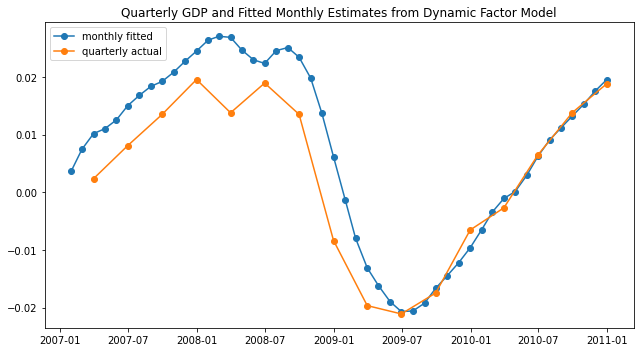

In [18]:
beg = '2006-12-31'
end = '2010-12-31'
fig, ax = plt.subplots(figsize=(9,5), num=1, clear=True)
y = fitted.fittedvalues['GDPC1']
y = y[(y.index > beg) & (y.index <= end)]
ax.plot_date(y.index, (scaler.inverse_transform(y)/3).cumsum(), fmt='-o', color='C0')
x = gdp.copy()
x.index = pd.DatetimeIndex(x.index.astype(str), freq=None)
x = x[(x.index > beg) & (x.index <= end)]
ax.plot_date(x.index, scaler.inverse_transform(x).cumsum(), fmt='-o',color='C1')
ax.legend(['monthly fitted', 'quarterly actual'], loc='upper left')
ax.set_title('Quarterly GDP and Fitted Monthly Estimates from Dynamic Factor Model')
plt.tight_layout()
plt.savefig(os.path.join(imgdir, f"mixedfreq.jpg"))
plt.show()

## Show "Nowcast" of GDP

In [19]:
Series({'Last Date of Monthly Data:': mdata.index[-1].strftime('%Y-%m-%d'),
        'Last Date of Quarterly Data:': qdata.index[-1].strftime('%Y-%m-%d'),
        'Forecast of Q1 GDP quarterly rate':
        scaler.inverse_transform(fitted.forecast('2020-03')['GDPC1'][[-1]])[0],
        'Forecast of Q2 GDP quarterly rate':
        scaler.inverse_transform(fitted.forecast('2020-06')['GDPC1'][[-1]])[0]},
       name = 'Forecast').to_frame()

,Forecast
Last Date of Monthly Data:,2020-01-31
Last Date of Quarterly Data:,2019-12-31
Forecast of Q1 GDP quarterly rate,0.006575
Forecast of Q2 GDP quarterly rate,0.006261


# Hidden Markov Model from FRED-MD
- HMM with Gaussian emissions
- Vary number of states and cov types to compare BIC's
- 'full' and 'tied' have too many parameters of cov matrix => lowest IC at 1 component
- 'spherical' constraints features same variance each state => too many components=9
- 'diag' cov matrix for each states => balanced: min IC at n_components=3

In [20]:
out = []
for covariance_type in ["full", "diag", "tied", "spherical"]:
    for n_components in range(1,16):
        markov = hmm.GaussianHMM(n_components=n_components,
                                 covariance_type=covariance_type,
                                 verbose=False, tol=1e-6, random_state=42, n_iter=100)\
                    .fit(mdata.values, [len(mdata)])
        results = hmm_summary(markov, mdata, [len(mdata)])
        #print(n_components, Series(results, name=covariance_type).to_frame().T)
        result = {'covariance_type': covariance_type,  'n_components': n_components}
        result.update(results)
        out.append(Series(result))
        result = pd.concat(out, axis=1).T.convert_dtypes()
print(result.to_string(float_format='{:.1f}'.format))

Fitting a model with 93131 free scalar parameters with only 88437 data points will result in a degenerate solution.
Fitting a model with 100905 free scalar parameters with only 88437 data points will result in a degenerate solution.
Fitting a model with 108681 free scalar parameters with only 88437 data points will result in a degenerate solution.
Fitting a model with 116459 free scalar parameters with only 88437 data points will result in a degenerate solution.


   covariance_type  n_components       aic        bic        p   neglogL
0             full             1  128221.3   163132.0     7626   56484.6
1             full             2  150688.0   289218.6    30261   45083.0
2             full             3  198664.0   509519.1    67904   31428.0
3             full             4  211003.7   762887.8   120555  -15053.1
4             full             5  330972.7  1192590.3   188214  -22727.6
5             full             6  445167.6  1685223.3   270881  -48297.2
6             full             7  601618.1  2288816.4   368556  -67747.0
7             full             8  784882.4  2987927.8   481239  -88797.8
8             full             9  965470.2  3753067.4   608930 -126194.9
9             full            10 1237527.2  4678380.6   751629 -132865.4
10            full            11 1524553.3  5687367.4   909336 -147059.4
11            full            12 1853015.6  6806495.1  1082051 -155543.2
12            full            13 2162150.9  7975000

## Display estimated transition and stationary distributions

In [21]:
n_components = 3
markov = hmm.GaussianHMM(n_components=n_components, covariance_type='diag',
                         verbose=False, tol=1e-6, random_state=42, n_iter=100)\
                         .fit(mdata.values, [len(mdata)])
pred = DataFrame(markov.predict(mdata), columns=['state'], index=mdata.index)
matrix = hmm_summary(markov, mdata, [len(mdata)], matrix=True)['matrix']
matrix

Transition Matrix:,0,1,2,Stationary
0,0.908187,0.051328,0.040485,0.386574
1,0.041765,0.905501,0.052733,0.429968
2,0.095580,0.113319,0.791101,0.183457


## Plot predicted states by selected economic series
- Recession state, recovery pre-2000 state and recoverty post-2000 state


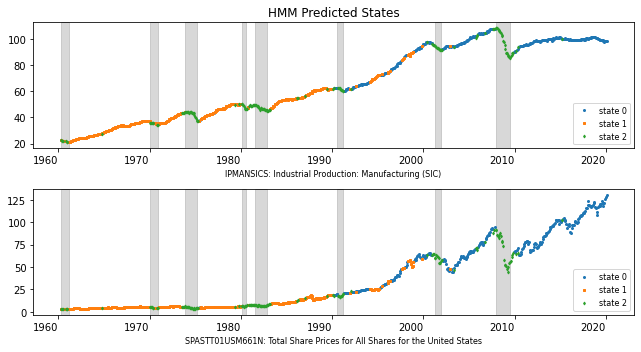

In [23]:
# helper to plot predicted states
def plot_states(modelname, labels, beg, end):
    n_components = len(np.unique(labels))
    markers = ["o", "s", "d", "X", "P", "8", "H", "*", "x", "+"][:n_components] 
    series_ids = ['IPMANSICS', 'SPASTT01USM661N']
    fig, axes = plt.subplots(len(series_ids),ncols=1,figsize=(9,5),num=1,clear=True)
    axes[0].set_title(f"{modelname.upper()} Predicted States", {'fontsize':12})
    for series_id, ax in zip(series_ids, axes.ravel()):
        df = alf(series_id)
        #print(df)
        df.index = pd.DatetimeIndex(df.index.astype(str), freq='infer')
        df = df[(df.index >= beg) & (df.index <= end)]
        for i, marker in zip(range(n_components), markers):
            df.loc[labels==i].plot(ax=ax, style=marker, markersize=2,
                                   color=f"C{i}", rot=0)
            ax.set_xlabel(f"{series_id}: {alf.header(series_id)}", {'fontsize':8})
        for a,b in vspans:
            if (b > min(df.index)) & (a < max(df.index)):
                ax.axvspan(max(a, min(df.index)), min(b, max(df.index)),
                           alpha=0.3, color='grey')
        ax.legend([f"state {i}" for i in range(n_components)], fontsize=8)
    plt.tight_layout()
    plt.savefig(os.path.join(imgdir, f"{modelname.lower()}.jpg"))

plot_states('hmm', pred.values.flatten(), min(pred.index), max(pred.index))
plt.show()

# Gaussian Mixtures Model from FRED-MD
- Fit with 3 states
- Plot predicted states, with representative economic time series


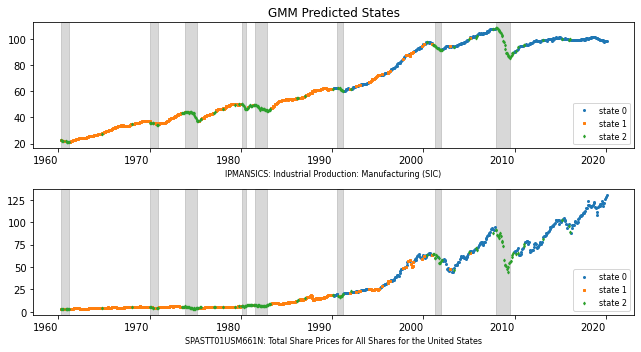

In [24]:
gmm = GaussianMixture(n_components=3, covariance_type='diag').fit(mdata)
labels = gmm.predict(mdata)
plot_states('GMM', labels, min(mdata.index), max(mdata.index))
plt.show()

## Compare persistance of states

In [32]:
print("Average Persistance of Hidden Markov states:",
      np.mean(pred[:-1].values == pred[1:].values))
print()
print('Stationary Distributiion of Hidden Markov:')
print(matrix.iloc[:,-1])
print()
print("Average Persistance of Gaussian Mixtures states:",
      np.mean(labels[:-1] == labels[1:]))
print()
print('Stationary Distribution of Gaussian Mixture:')
print(Series(labels).value_counts().sort_index()/len(labels))

Average Persistance of Hidden Markov states: 0.8857938718662952

Stationary Distributiion of Hidden Markov:
0    0.386574
1    0.429968
2    0.183457
Name: Stationary, dtype: float64

Average Persistance of Gaussian Mixtures states: 0.841225626740947

Stationary Distribution of Gaussian Mixture:
0    0.375522
1    0.429764
2    0.194715
dtype: float64
